In [1]:
import pyam
import pandas as pd
import numpy as np
import itertools

import tradeoff.ecpc_calculator as tecpc

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.container import ErrorbarContainer
from matplotlib.collections import LineCollection

from pathlib import Path
import copy

<IPython.core.display.Javascript object>

Step 1: Read in the necessary data.

In [2]:
df = pyam.IamDataFrame(
    Path(
        '../data/101_data.xlsx'
    )
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/101_data.xlsx
pyam.core - INFO: Reading meta indicators


Step 2: Downselect the necessary data.

In [3]:
df_for_equity_indices = (
    df
    .filter(
        region='R5*',
        variable=[
            'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross',
            'Population'
        ],
        year=range(2010, 2101)
    )
    .interpolate(
        time=range(2010, 2101)
    )
)

In [4]:
df_for_equity_indices.aggregate_region(
    region='World',
    variable=df_for_equity_indices.variable,
    subregions=df_for_equity_indices.region,
    append=True
)

Step 3: Calculate the fair share emissions on an equal per capita basis.

In [5]:
df_for_equity_indices.require_variable(
    'Population',
    exclude_on_fail=True
)
df_for_equity_indices.filter(
    exclude=False,
    inplace=True
)

/var/folders/nz/kr7bwztj0_d9xrfz1jd4zcdh0000gp/T/ipykernel_2476/3427996769.py:1: DeprecationWarning: This method is deprecated and will be removed in future versions. Use `df.require_data()` instead.
  df_for_equity_indices.require_variable(
pyam.core - INFO: 19 scenarios do not include required variable `Population`, marked as `exclude: True` in `meta`


In [6]:
results = []
for (mod, scen) in df_for_equity_indices.meta.index:
    df_to_crunch = df_for_equity_indices.filter(
        model=mod,
        scenario=scen
    )
    result = tecpc.calculate_carbon_debt(
        in_df=df_to_crunch,
        emission_var='AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross',
        start_year=2010,
        end_year=2100
    )
    results.append(result)

In [7]:
results_pyam = pyam.concat(
    results
)

Step 4: We need to calculate the debt (gross) between 2010 and 2020. This will serve two purposes:
1. Use the proportions to calculate this historical CDR debt (i.e., did you deploy enough)
2. Calculate the gross debt that will be added to the future per capita gross allocations.

In [8]:
r5_regions = [
    x for x in results_pyam.region if 'R5' in x
]

In [9]:
debt = (
    results_pyam
    .filter(
        variable='Emissions|Debt',
        year=range(2010,2021),
        region=r5_regions
    )
)

In [10]:
for region in debt.region:
    region_ts = (
        debt
        .filter(region=region)
        .timeseries()
    )

    region_ts_pos_nly = copy.deepcopy(region_ts)
    region_ts_pos_nly[region_ts_pos_nly<0] = 0

    debt.set_meta(
        region_ts.apply(
            lambda x: pyam.cumulative(
                x,
                first_year=2010,
                last_year=2020
            ),
            axis=1
        ),
        name=f'debt_2010_2020_{region}'
    )

    debt.set_meta(
        region_ts_pos_nly.apply(
            lambda x: pyam.cumulative(
                x,
                first_year=2010,
                last_year=2020
            ),
            axis=1
        ),
        name=f'debt_2010_2020_for_shares_{region}'
    )

In [11]:
debt_share_columns = [
    x for x in  debt.meta.columns if 'for_shares' in x
]

In [12]:
for region in r5_regions:
    debt.meta.loc[:, f'share_debt_{region}'] = (
        debt.meta.loc[:, f'debt_2010_2020_for_shares_{region}']
        /
        (debt.meta.loc[:, debt_share_columns].sum(axis=1))
    )

Step 5: Now, let us calculate the total (historical) CDR deployed in this period.

In [13]:
df.set_meta(
    name='exclude',
    meta=True,
    index=df.meta.index.difference(debt.index)
)

In [14]:
df.filter(
    exclude=False,
    inplace=True
)

In [15]:
total_cdr = (
    df
    .filter(
        variable='AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total',
    )
)

In [16]:
year_pairs = [
    (2010, 2020),
    (2021, 'netzero')
]

In [17]:
for region in total_cdr.region:
    reg_ts = (
        total_cdr
        .filter(
            region=region
        )
        .timeseries()
    )
    for start, end in year_pairs:
        if end=='netzero':
            debt.set_meta(
                reg_ts.apply(
                    lambda x: pyam.cumulative(
                        x,
                        first_year=start,
                        last_year=debt.meta.loc[x.name[0:2], 'Year of netzero CO2 emissions (Harm-Infilled) table']
                    ),
                    axis=1
                ),
                name=f'cdr_{start}_{end}_{region}'
            )
        else:
            debt.set_meta(
                reg_ts.apply(
                    lambda x: pyam.cumulative(
                        x,
                        first_year=start,
                        last_year=end
                    ),
                    axis=1
                ),
                name=f'cdr_{start}_{end}_{region}'
            )

Step 6: Now, let us calculate the fair CDR in the historical period as well as the "CDR debt"

In [18]:
for region in r5_regions:
    debt.meta.loc[:, f'cdr_fair_2010_2020_{region}'] = (
        debt.meta.loc[:,f'share_debt_{region}'] * debt.meta.loc[:, 'cdr_2010_2020_World']
    )

    debt.meta.loc[:, f'cdr_debt_2010_2020_{region}'] = (
        debt.meta.loc[:, f'cdr_fair_2010_2020_{region}'] - debt.meta.loc[:, f'cdr_2010_2020_{region}']
    )

    debt.meta.loc[:, f'cdr_debt_for_shares_2010_2020_{region}'] = (
        debt.meta.loc[:, f'cdr_debt_2010_2020_{region}'].apply(
            lambda x: x if x>=0 else 0
        )    
    )
    

Step 7: Calculate the shares of this historical CDR debt (0 share if negative)

In [19]:
cdr_debt_share_columns = [
    x for x in debt.meta.columns if 'cdr_debt_for_shares' in x
]

In [20]:
for region in r5_regions:
    debt.meta.loc[:, f'cdr_share_2021_netzero_{region}'] = (
        debt.meta.loc[:, f'cdr_debt_for_shares_2010_2020_{region}']
        /
        (debt.meta.loc[:, cdr_debt_share_columns].sum(axis=1))
    )

Step 8: Calculate the fair CDR benchmark

In [21]:
for region in r5_regions:
    debt.meta.loc[:, f'benchmark_cdr_2021_netzero_{region}'] = (
        debt.meta.loc[:, f'cdr_share_2021_netzero_{region}'] * debt.meta.loc[:, 'cdr_2021_netzero_World']         
    )

Step 9: Calculate the fair gross emission benchmark.

In [22]:
fair_gross = (
    results_pyam
    .filter(
        variable='Emissions|Fair',
        year=range(2021, 2101),
        region=r5_regions
    )
)

In [23]:
for region in r5_regions:
    reg_ts = (
        fair_gross
        .filter(region=region)
        .timeseries()
    )
    debt.set_meta(
        reg_ts.apply(
            lambda x: pyam.cumulative(
                x,
                first_year=2021,
                last_year=debt.meta.loc[x.name[0:2], 'Year of netzero CO2 emissions (Harm-Infilled) table']
            ),
            axis=1
        ),
        name=f'benchmark_gross_2021_netzero_wodebt_{region}'
    )
    debt.meta.loc[:, f'benchmark_gross_2021_netzero_wdebt_{region}'] = (
        debt.meta.loc[:, f'benchmark_gross_2021_netzero_wodebt_{region}']
        -
        debt.meta.loc[:, f'debt_2010_2020_{region}']
    )

Step 10: Finally let us estimate the total gross emissions from 2021 to netzero

In [24]:
gross = (
    results_pyam
    .filter(
        variable='AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross'
    )
)

In [25]:
for region in r5_regions:
    gross_reg_ts = (
        gross
        .filter(
            region=region
        )
        .timeseries()
    )
    debt.set_meta(
        gross_reg_ts
        .apply(
            lambda x: pyam.cumulative(
                x,
                first_year=2021,
                last_year=debt.meta.loc[x.name[0:2], 'Year of netzero CO2 emissions (Harm-Infilled) table']
            ),
            axis=1
        ),
        name=f'gross_2021_netzero_{region}'
    )

Step 11: Assessment and statements. Does this style of analysis lead to any new insights.

In [26]:
string_types = [
    'gross_2021_netzero_',
    'cdr_2021_netzero_'
]

In [27]:
cols = [['Category']]
for s in string_types:
    c = [x for x in debt.meta.columns if s in x]
    cols.append(c)

In [28]:
cols_to_assess = list(itertools.chain(*cols))

In [29]:
cols_to_assess

['Category',
 'benchmark_gross_2021_netzero_wodebt_R5ASIA',
 'benchmark_gross_2021_netzero_wdebt_R5ASIA',
 'benchmark_gross_2021_netzero_wodebt_R5LAM',
 'benchmark_gross_2021_netzero_wdebt_R5LAM',
 'benchmark_gross_2021_netzero_wodebt_R5MAF',
 'benchmark_gross_2021_netzero_wdebt_R5MAF',
 'benchmark_gross_2021_netzero_wodebt_R5OECD90+EU',
 'benchmark_gross_2021_netzero_wdebt_R5OECD90+EU',
 'benchmark_gross_2021_netzero_wodebt_R5REF',
 'benchmark_gross_2021_netzero_wdebt_R5REF',
 'gross_2021_netzero_R5ASIA',
 'gross_2021_netzero_R5LAM',
 'gross_2021_netzero_R5MAF',
 'gross_2021_netzero_R5OECD90+EU',
 'gross_2021_netzero_R5REF',
 'cdr_2021_netzero_R5ASIA',
 'cdr_2021_netzero_R5LAM',
 'cdr_2021_netzero_R5MAF',
 'cdr_2021_netzero_R5OECD90+EU',
 'cdr_2021_netzero_R5REF',
 'cdr_2021_netzero_World',
 'benchmark_cdr_2021_netzero_R5ASIA',
 'benchmark_cdr_2021_netzero_R5LAM',
 'benchmark_cdr_2021_netzero_R5MAF',
 'benchmark_cdr_2021_netzero_R5OECD90+EU',
 'benchmark_cdr_2021_netzero_R5REF']

In [30]:
fig2_data = debt.meta[cols_to_assess]

In [31]:
fig2_data = fig2_data[fig2_data['Category']=='C1']

In [32]:
r5_regions

['R5ASIA', 'R5LAM', 'R5MAF', 'R5OECD90+EU', 'R5REF']

In [33]:
def plot_median_iqr(ax, data, column,i, color, multiply=1, **kwargs):
    ax.bar(
        x=i,
        height=data[column].median()*multiply,
        color=color,
        width=0.2,
        **kwargs
    )
    ax.errorbar(
        x=[i,i],
        y=[data[column].quantile(q=0.25)*multiply, data[column].quantile(q=0.75)*multiply],
        color='black',
        marker='_'
    )

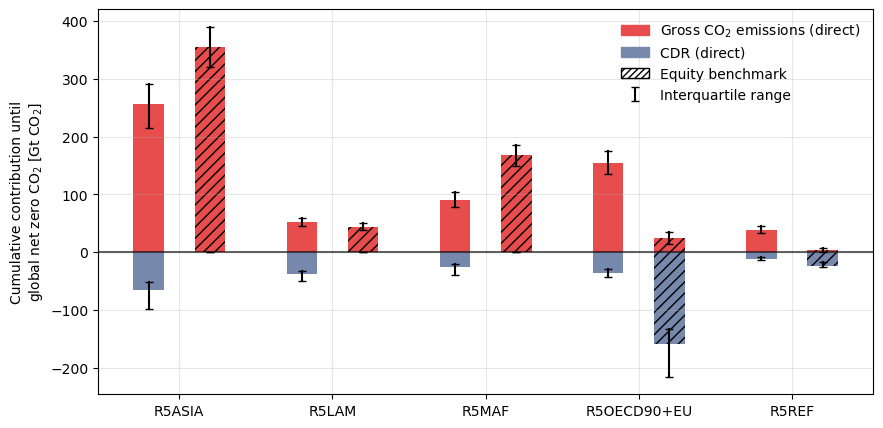

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))

for i, region in enumerate(r5_regions):
    plot_median_iqr(
        ax,
        fig2_data,
        f'gross_2021_netzero_{region}',
        i-0.2,
        '#e74d4d'
    )

    plot_median_iqr(
        ax,
        fig2_data,
        f'cdr_2021_netzero_{region}',
        i-0.2,
        '#7688ab',
        multiply=-1
    )

    plot_median_iqr(
        ax,
        fig2_data,
        f'benchmark_gross_2021_netzero_wdebt_{region}',
        i+0.2,
        '#e74d4d',
        hatch='///'
    )

    plot_median_iqr(
        ax,
        fig2_data,
        f'benchmark_cdr_2021_netzero_{region}',
        i+0.2,
        '#7688ab',
        -1,
        hatch='///'
    )

ax.set_ylabel('Cumulative contribution until\nglobal net zero CO$_2$ [Gt CO$_2$]')

# Make a custom legend

line = Line2D([],[], ls="none", color='black')
barline = LineCollection(np.empty((2,2,2)), color='black')
custom_legend = [
    Patch(facecolor='#e74d4d', label='Gross CO$_2$ emissions (direct)', edgecolor='#e74d4d'),
    Patch(facecolor='#7688ab', label='CDR (direct)', edgecolor='#7688ab'),
    Patch(label='Equity benchmark', hatch='/////', edgecolor='black',facecolor='white'),
    ErrorbarContainer((line, [line], [barline]), has_yerr=True, label='Interquartile range')
]
ax.legend(handles=custom_legend, framealpha=0)

ax.set_xticks(range(5), r5_regions)
ax.grid(alpha=0.3)
ax.axhline(0, color='black', alpha=0.6)

In [35]:
fig.savefig(
    Path(
        'figures/fig2.png'
    ),
    dpi=600,
    bbox_inches='tight'
)